This notebook was run using the updated phage table with false MCPs removed

##### Author:
    Diana Y. Lee, Luque Lab, SDSU
    dlee@sdsu.edu

##### Purpose:

    Creates a kernel distribution for analyzing the MCP database
    Applies the G2T model to the MCP database
    Creates the base illustrations for Figure 3 and related SI of the paper in preparation titled, [TBD]

##### Requires: 
    data\AllDNA.csv
    data\PHAGE_TABLE3.xlsx
    phage_functions.ipynb
    
    
##### Database file: 
    item2_update.db
    
##### Creates:
    MCP Kernel Density all.svg
    Fig3a-MCP Kernel Density.svg
    Fig3c-Percent architectures predicted by T-number.svg
    Fig3b-Predicted T-numbers for MCP.svg
    MCP Kernel Density (hex).svg
    MCP Kernel Density (trihex).svg
    Fig3bSI-Predicted T-numbers for Unassigned MCP.svg	


In [1]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
np.random.seed(8)
import math
import copy
import csv

# imports for the peak identification functions


In [3]:
from ipynb.fs.full.phage_functions import tNearest
from ipynb.fs.full.phage_functions import tNearestFloor
from ipynb.fs.full.phage_functions import tNearestValid
from ipynb.fs.full.phage_functions import tModel
from ipynb.fs.full.phage_functions import tNum
from ipynb.fs.full.phage_functions import tList

In [2]:
# set the fontsize
font1 = 24
font2 = 20
font3 = 16

In [4]:
tNum(350)

32.16004144682459

In [5]:
#create a list of possible, valid T-numbers, as well as separate t-number lists for T_h and T_t 
tps2, tps, tps_t, tps_h = tList(7)

In [6]:
# t-numbers that are seen in both lists are 4*t, where t equals possible T_t numbers
for i in tps_h:
    if i in tps_t:
        print(i)

4.0
12.0
16.0
28.0
36.0
48.0
52.0


In [7]:
errMargin = 0.09

In [8]:
tMod = tModel()
print(tps)
TDNA = np.exp((np.log(tps)-tMod[2])/tMod[0])
print(TDNA)

[  1.     1.33   3.     4.     5.33   7.     9.     9.33  12.    13.
  16.    17.33  19.    21.    21.33  25.    25.33  27.    28.    31.
  33.33  36.    37.    37.33  39.    41.33  43.    48.    49.    49.33
  52.    57.33  61.    63.    64.    65.33  69.33  75.    76.    81.33
  84.    91.   100.   101.33 108.   121.33 144.  ]
[2.71369912e+00 4.04553171e+00 1.26361489e+01 1.89038723e+01
 2.82557371e+01 4.13853342e+01 5.88393377e+01 6.18821356e+01
 8.80245504e+01 9.84638544e+01 1.31686076e+02 1.47263772e+02
 1.67509695e+02 1.92707895e+02 1.96961287e+02 2.45992420e+02
 2.50550903e+02 2.73981233e+02 2.88293963e+02 3.32451572e+02
 3.67956901e+02 4.09880122e+02 4.25910009e+02 4.31238266e+02
 4.58490006e+02 4.97296485e+02 5.25657255e+02 6.13186940e+02
 6.31148042e+02 6.37107618e+02 6.85908071e+02 7.86327289e+02
 8.57699393e+02 8.97330746e+02 9.17337055e+02 9.44139687e+02
 1.02605991e+03 1.14544638e+03 1.16688761e+03 1.28305780e+03
 1.34242054e+03 1.50162540e+03 1.71360533e+03 1.74560134e+0

In [9]:
# kernel density import
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

# function to build kernel density data
# https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

kde_funcname = 'Scikit-learn'

In [10]:
# import original temperate, virulent, and marine phage data
AllDNAdata = pd.read_csv("AllDNA.csv")

xLt1 = np.asarray(AllDNAdata["Lytic"]).reshape(-1, 1)
xLg1 = np.asarray(AllDNAdata["Lysogenic"]).reshape(-1, 1)
xMp1 = np.asarray(AllDNAdata["Marine"]).reshape(-1, 1)

all_xlin = []
all_pdfs = []

# Create an array of the data
pops1 = [xLt1, xLg1, xMp1]
pops2 = ["Virulent","Temperate","Marine"]

for x in pops1:
    # remove NaN
    x = x[~(np.isnan(x))]
    # convert from kbp to bp
    x = x/1000
    # create x linspace
    xlin = np.linspace(0,max(x)+10, 1000)
    all_xlin.append(xlin)
    # check for best bandwidth
    grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(1, 30, 30)},
                    cv=50) # 50-fold cross-validation
    grid.fit(x[:, None])
    pdf1 = kde_sklearn(x, xlin, bandwidth=grid.best_params_['bandwidth'])
    all_pdfs.append(pdf1)
    print(grid.best_params_)


{'bandwidth': 11.0}
{'bandwidth': 12.0}
{'bandwidth': 12.0}


In [11]:
# import updated MCP database
phageData = pd.read_excel("PHAGE_TABLE3.xlsx")

# grab the complete genome size
xMCP1 = np.asarray(phageData["COMPLETE_GENOME_BP"]).reshape(-1, 1)
xMCP1 = xMCP1[~(np.isnan(xMCP1))]
xMCP1 = xMCP1/1000
xlinMCP = np.linspace(0,max(xMCP1)+10, int(max(xMCP1)+10))
n = len(xMCP1)

# grab the index
IxMCP = np.asarray(phageData["ID"]).reshape(-1, 1)
IxMCP = IxMCP[~(np.isnan(IxMCP))]

# check for best bandwidth
grid = GridSearchCV(KernelDensity(),
                {'bandwidth': np.linspace(1, 30, 30)},
                cv=50) # 20-fold cross-validation
grid.fit(xMCP1[:, None])
print(grid.best_params_)

# create kernel density estimates
pdfMCP = kde_sklearn(xMCP1, xlinMCP, bandwidth=grid.best_params_['bandwidth'])

{'bandwidth': 4.0}


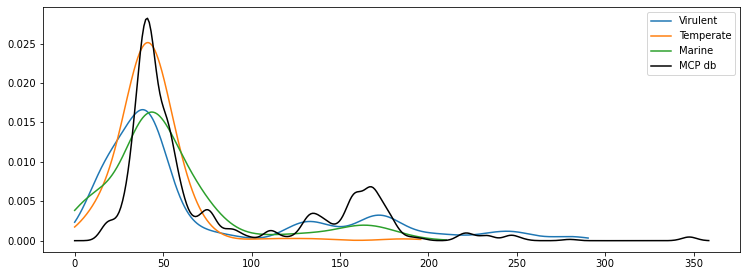

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12.5, 4.5))
for i in range(3):
    plt.plot(all_xlin[i], all_pdfs[i],label=pops2[i])
plt.plot(xlinMCP, pdfMCP, color='black', label='MCP db') 
plt.legend()

In [13]:
# find the maximum value from all the estimates and use it to set an upper y limit
# we do this to ensure that all of our plots are similarly scaled
maxYlim = 0
for i in all_pdfs:
    if maxYlim < max(i):
        maxYlim = max(i)
if maxYlim < max(pdfMCP):
        maxYlim = max(pdfMCP)
maxYlim = round(maxYlim+.005,2)

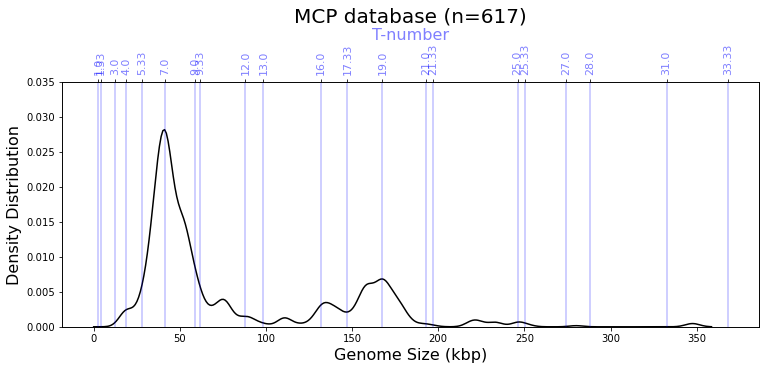

In [14]:
# MCP database kernel dist
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12.5, 4.5))
plt.plot(xlinMCP, pdfMCP, color='black', label='MCP db') 
plt.ylim((0,.035))
#plt.legend(loc="upper right")

y_range = np.linspace(0,.035,2)

tnums = tps[:21]
x_tnums = TDNA[:21]

for i in range(len(tnums)):
    x_range = [x_tnums[i],x_tnums[i]]
    plt.plot(x_range,y_range, color="blue",alpha=0.25)
    
# add another x
new_tick_locations = np.array(x_tnums)
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tnums, fontsize=11, color="blue",alpha=0.5, rotation=90)
ax2.set_xlabel("T-number", fontsize=font3, color="blue",alpha=0.5)

#plt.title("MCP database (n=617)", fontsize=font2)
ax.set_title("MCP database (n=617)", fontsize=font2, pad=60)
ax.set_xlabel("Genome Size (kbp)", fontsize=font3)
ax.set_ylabel("Density Distribution", fontsize=font3)
plt.savefig("MCP Kernel Density all.png")
plt.savefig("MCP Kernel Density all.svg");

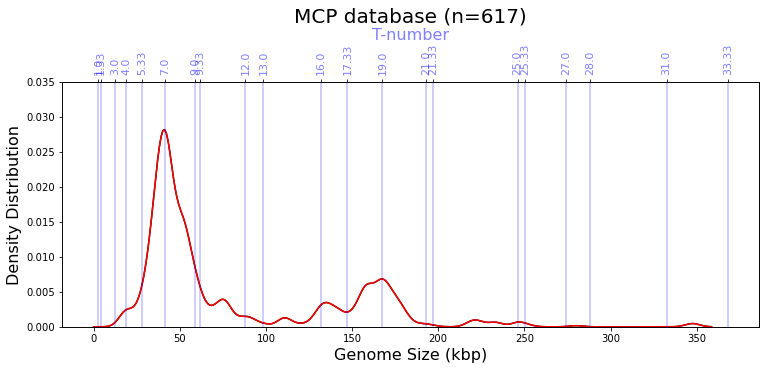

In [15]:
# create kernel density estimates
pdfMCP2 = kde_sklearn(xMCP1, xlinMCP, bandwidth=4)

# MCP database kernel dist
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12.5, 4.5))
plt.plot(xlinMCP, pdfMCP, color='black', label='bw=2') 
plt.plot(xlinMCP, pdfMCP2, color='red', label='bw=4') 
plt.ylim((0,.035))
#plt.legend(loc="upper right")


y_range = np.linspace(0,.035,2)

tnums = tps[:21]
x_tnums = TDNA[:21]

for i in range(len(tnums)):
    x_range = [x_tnums[i],x_tnums[i]]
    plt.plot(x_range,y_range, color="blue",alpha=0.25)
    
# add another x
new_tick_locations = np.array(x_tnums)
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tnums, fontsize=11, color="blue",alpha=0.5, rotation=90)
ax2.set_xlabel("T-number", fontsize=font3, color="blue",alpha=0.5)

#plt.title("MCP database (n=617)", fontsize=font2)
ax.set_title("MCP database (n=617)", fontsize=font2, pad=60)
ax.set_xlabel("Genome Size (kbp)", fontsize=font3)
ax.set_ylabel("Density Distribution", fontsize=font3)

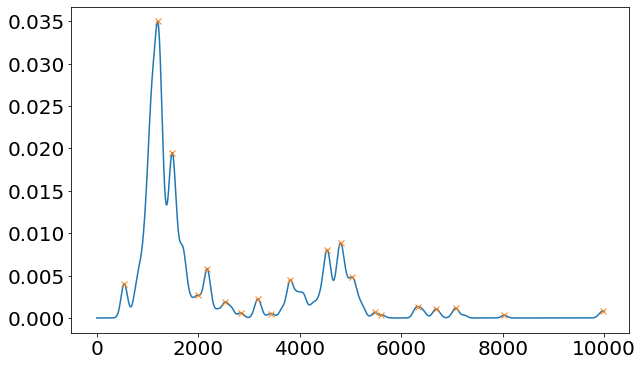

In [16]:
from scipy.signal import find_peaks

xlinMCP2 = np.linspace(0,max(xMCP1), 10000)
pdfMCP2 = kde_sklearn(xMCP1, xlinMCP2, bandwidth=2)

peaks, _ = find_peaks(pdfMCP2, height=0)

peaks2 = []
for i in peaks: 
    peaks2.append(i)
    
peaks2 = np.sort(np.asarray(peaks2))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
plt.plot(pdfMCP2)
plt.plot(peaks2, pdfMCP2[peaks2], "x")
#plt.plot(np.zeros_like(pdfMCP), "--", color="gray")
plt.xticks(fontsize=font2)
plt.yticks(fontsize=font2)
plt.show()

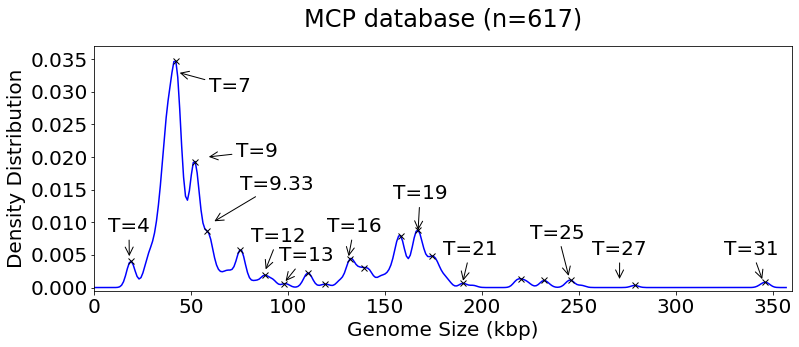

In [9]:
xlinMCP2 = np.linspace(0,max(xMCP1)+10, int(max(xMCP1)+10))
pdfMCP2 = kde_sklearn(xMCP1, xlinMCP2, bandwidth=2)

peaks, _ = find_peaks(pdfMCP2, height=0)

dList = [0, 50, 100, 150, 200, 250, 300, 350]
dLog = copy.copy(dList)

peaks2 = []
for i in peaks: 
    peaks2.append(i)
    
peaks2.append(58) # shoulder around 9
peaks2.append(139) # shoulder around 16
peaks2 = np.sort(np.asarray(peaks2))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12.5, 4.5))
plt.plot(pdfMCP2, color="blue")
plt.plot(peaks2, pdfMCP2[peaks2], "x", color="black")
#plt.plot(np.zeros_like(pdfMCP), "--", color="gray")
ax.annotate("T=4", xy=(18,0.0045), xytext=(7, 0.0085),arrowprops=dict(arrowstyle="->"), fontsize=font2)
ax.annotate("T=7", xy=(43,0.033), xytext=(59, 0.03),arrowprops=dict(arrowstyle="->"), fontsize=font2)
ax.annotate("T=9", xy=(58,0.020), xytext=(73, 0.020),arrowprops=dict(arrowstyle="->"), fontsize=font2)
ax.annotate("T=9.33", xy=(61,0.01), xytext=(75, 0.015),arrowprops=dict(arrowstyle="->"), fontsize=font2)
ax.annotate("T=12", xy=(88,0.0025), xytext=(81, 0.007),arrowprops=dict(arrowstyle="->"), fontsize=font2)
ax.annotate("T=13", xy=(98,0.00075), xytext=(95, 0.004),arrowprops=dict(arrowstyle="->"), fontsize=font2)
ax.annotate("T=16", xy=(131,0.0045), xytext=(120, 0.0085),arrowprops=dict(arrowstyle="->"), fontsize=font2)
ax.annotate("T=19", xy=(167,0.0085), xytext=(154, 0.0135),arrowprops=dict(arrowstyle="->"), fontsize=font2)
ax.annotate("T=21", xy=(190,0.00075), xytext=(180, 0.005),arrowprops=dict(arrowstyle="->"), fontsize=font2)
ax.annotate("T=25", xy=(245,0.0015), xytext=(225, 0.0075),arrowprops=dict(arrowstyle="->"), fontsize=font2)
ax.annotate("T=27", xy=(271,0.001), xytext=(257, 0.005),arrowprops=dict(arrowstyle="->"), fontsize=font2)
ax.annotate("T=31", xy=(345,0.001), xytext=(325, 0.005),arrowprops=dict(arrowstyle="->"), fontsize=font2)


plt.ylim((-0.0005,.037))
plt.xlim((0,360))
ax.set_title("MCP database (n=617)", fontsize=font1, pad=20)
ax.set_xlabel("Genome Size (kbp)", fontsize=font2)
plt.xticks(dLog, dList,fontsize=font2)
plt.yticks(fontsize=font2)
plt.ylabel("Density Distribution", fontsize=font2)
xlinMCP2 = np.linspace(min(xMCP1),max(xMCP1)+10, 350)
pdfMCP2 = kde_sklearn(xMCP1, xlinMCP2, bandwidth=2)
plt.savefig("Fig3a-MCP Kernel Density.png")
plt.savefig("Fig3a-MCP Kernel Density.svg");

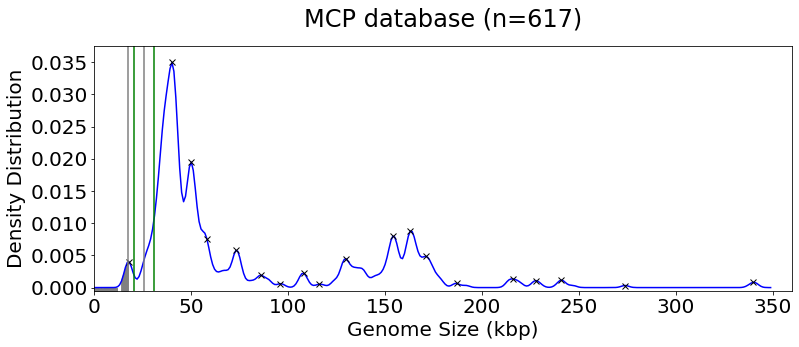

In [11]:
xlinMCP2 = np.linspace(1,max(xMCP1)+8, 350)
pdfMCP2 = kde_sklearn(xMCP1, xlinMCP2, bandwidth=2)

peaks, _ = find_peaks(pdfMCP2, height=0)

dList = [0, 50, 100, 150, 200, 250, 300, 350]
dLog = copy.copy(dList)

peaks2 = []
for i in peaks: 
    peaks2.append(i)
    
peaks2.append(58) # shoulder for 9
peaks2 = np.sort(np.asarray(peaks2))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12.5, 4.5))
plt.plot(pdfMCP2, color="blue")
plt.plot(peaks2, pdfMCP2[peaks2], "x", color="black")

#between 0 and T=1
plt.fill_between([0,2.469466], [7.6265E-06],-0.0005,color='gray')
#T=1
plt.fill_between([0,2.469466], [7.6265E-06],-0.0005,color='gray')
#between T=1 and T=1.33
plt.fill_between([2.95793204,3.68143386], [7.6265E-06],-0.0005,color='gray')
#between T=1.33 and T=3
plt.fill_between([4.40962957,11.49889549], [7.6265E-06],-0.0005,color='gray')
#between T=3 and T=4
plt.fill_between([13.77340229, 17.20252378], [0.00111862653962, 0.00426362377],-0.0005,color='gray')
#between T=4 and T=5.33


a_test=[-0.0005,.0375]
#for i in range(7):
plt.plot([tps3_DNA[3][2],tps3_DNA[3][2]],a_test, color="gray")
plt.plot([tps3_DNA[3][3],tps3_DNA[3][3]],a_test, color="green")
plt.plot([tps3_DNA[4][2],tps3_DNA[4][2]],a_test, color="gray")
plt.plot([tps3_DNA[4][3],tps3_DNA[4][3]],a_test, color="green")

plt.ylim(a_test)
plt.xlim((0,360))
ax.set_title("MCP database (n=617)", fontsize=font1, pad=20)
ax.set_xlabel("Genome Size (kbp)", fontsize=font2)
plt.xticks(dLog, dList,fontsize=font2)
plt.yticks(fontsize=font2)
plt.ylabel("Density Distribution", fontsize=font2)
plt.savefig("Fig3a-MCP Kernel Density_TEST.svg");

In [221]:
ad5x=[21.37432665,22.39304298, 23.41175931, 24.43047564, 25.44919198]
#ad5y = 0.001333+0.00015(-11.4908+0.4908*ad5x)+0.00109*(np.square(-11.4908+0.4908*ad5x))
0.001333+0.00015*(-11.4908+np.multiply(0.4908,ad5x))+0.00109*(np.square(-11.4908+np.multiply(0.4908,ad5x)))


array([0.00227357, 0.00153078, 0.00133295, 0.0016801 , 0.00257222])

In [214]:
p_fitted = np.polynomial.Polynomial.fit([21.37432665,22.39304298, 23.41175931, 24.43047564, 25.44919198],[0.00227739418, 0.00152967462, 0.00131623867, 0.00170450988, 0.00256872592]
, deg=2)
p_fitted

Polynomial([0.0013328 , 0.0001515 , 0.00109302], domain=[21.37432665, 25.44919198], window=[-1.,  1.])

In [154]:
shading_array1 = []
for i in range(len(xlinMCP2)):
    shading_array1.append(xlinMCP2[i])
    shading_array1.append(pdfMCP2[i])
    
shading_array1 = np.asarray(np.reshape(np.ravel(shading_array1), (-1, 2)));

for i in range(tps3_DNA.shape[0]):
    print(tps3_DNA[i][0])
    for j in range(shading_array1.shape[0]):
        if (shading_array1[j][0]>=tps3_DNA[i][2] and shading_array1[j][0]<=tps3_DNA[i][3]):
            print(shading_array1[j])

1.0
1.33
[4.05614900e+00 1.72889657e-13]
3.0
[1.22058797e+01 3.66121129e-05]
[1.32245960e+01 1.40059553e-04]
4.0
[1.72994613e+01 3.15262377e-03]
[1.83181777e+01 3.92802450e-03]
[1.93368940e+01 3.94903899e-03]
[2.03556103e+01 3.25169699e-03]
5.33
[2.64679083e+01 3.66583086e-03]
[2.74866246e+01 4.74550849e-03]
[2.85053410e+01 5.67412199e-03]
[2.95240573e+01 6.52501615e-03]
[3.05427736e+01 7.55892751e-03]
7.0
[3.76737880e+01 2.74544125e-02]
[3.86925043e+01 2.98355033e-02]
[3.97112206e+01 3.19930953e-02]
[4.07299370e+01 3.40022076e-02]
[4.17486533e+01 3.49651046e-02]
[4.27673696e+01 3.36010659e-02]
[4.37860860e+01 2.95518703e-02]
[4.48048023e+01 2.39311355e-02]
9.0
[5.39732493e+01 1.55140522e-02]
[5.49919656e+01 1.25280670e-02]
[5.60106819e+01 1.02577224e-02]
[5.70293983e+01 9.10204432e-03]
[5.80481146e+01 8.74583308e-03]
[5.90668309e+01 8.44576460e-03]
[6.00855473e+01 7.60985934e-03]
[6.11042636e+01 6.22921711e-03]
[6.21229799e+01 4.74815504e-03]
[6.31416963e+01 3.58109572e-03]
9.33
[5.70

In [158]:
# create a truncated t list with zero at the end
tps3 = tps[:21]
tps3 = np.insert(tps3,21,0)
tps3
tps3_DNA = []

for i in range(21):
    tps3_DNA.append(tps3[i])
    tps3_DNA.append(TDNA[i])
    tps3_DNA.append(TDNA[i]-TDNA[i]*errMargin)
    tps3_DNA.append(TDNA[i]+TDNA[i]*errMargin)

tps3_DNA = np.reshape(np.ravel(tps3_DNA), (21, 4));
tps3_DNA = np.asarray(tps3_DNA)

print("  T-num  ---  exact DNA  ---  low DNA  ---  high DNA")
print(tps3_DNA)

  T-num  ---  exact DNA  ---  low DNA  ---  high DNA
[[  1.           2.71369912   2.4694662    2.95793204]
 [  1.33         4.04553171   3.68143386   4.40962957]
 [  3.          12.63614889  11.49889549  13.77340229]
 [  4.          18.90387229  17.20252378  20.60522079]
 [  5.33        28.25573708  25.71272074  30.79875342]
 [  7.          41.38533419  37.66065411  45.11001426]
 [  9.          58.83933768  53.54379729  64.13487807]
 [  9.33        61.88213564  56.31274344  67.45152785]
 [ 12.          88.02455041  80.10234087  95.94675994]
 [ 13.          98.46385437  89.60210748 107.32560127]
 [ 16.         131.68607567 119.83432886 143.53782248]
 [ 17.33       147.26377226 134.01003276 160.51751177]
 [ 19.         167.50969542 152.43382283 182.58556801]
 [ 21.         192.70789497 175.36418442 210.05160552]
 [ 21.33       196.96128748 179.23477161 214.68780336]
 [ 25.         245.99241971 223.85310193 268.13173748]
 [ 25.33       250.55090292 228.00132165 273.10048418]
 [ 27.      

In [19]:
peaks

array([ 19,  42,  52,  75,  88,  98, 110, 119, 132, 158, 167, 174, 190,
       220, 232, 246, 279, 346], dtype=int64)

In [20]:
# grab the MCP protein length only
xMCPOnly1 = np.asarray(phageData["PROTEIN_BP"]).reshape(-1, 1)
xMCPOnly1 = xMCPOnly1[~(np.isnan(xMCPOnly1))]
xlinMCPOnly = np.linspace(min(xMCPOnly1),max(xMCPOnly1), 1000)

# create kernel density estimate
pdfMCPOnly = kde_sklearn(xMCPOnly1, xlinMCPOnly, bandwidth=20)


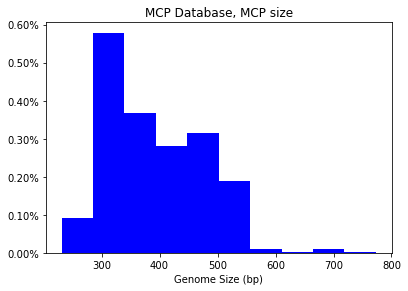

In [21]:
fig = plt.figure()
fig.figsize=(15,15)
ax = fig.add_axes([0, 0, .8, 0.8])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.2%}'))
plt.hist(xMCPOnly1, density=True, color='blue')
plt.xlabel("Genome Size (bp)")
plt.title("MCP Database, MCP size")
plt.show()

In [22]:
# calculate T-numbers for the MCP database

tRaw1 = tNum(xMCP1)
tNearest1 = []
for k in tRaw1:
    tNearest1.append(tNearestValid(tps,k,errMargin))
    
tNearest1 = np.asarray(tNearest1)

In [23]:
from collections import Counter

words = tNearest1

print(Counter(words).keys()) # equals to list(set(words))
print(Counter(words).values()) # counts the elements' frequency

dict_keys([5.33, 0.0, 7.0, 19.0, 9.0, 12.0, 16.0, 17.33, 9.33, 4.0, 25.0, 21.0, 31.0, 13.0, 21.33, 25.33, 27.0])
dict_values([24, 103, 198, 86, 68, 16, 29, 28, 16, 14, 12, 7, 3, 7, 4, 1, 1])


In [24]:
noTnum = Counter(words)[0]/len(xMCP1)
print( "{:.1%}".format(noTnum) )

16.7%


In [22]:
Counter(words)

Counter({5.33: 24,
         0.0: 103,
         7.0: 198,
         19.0: 86,
         9.0: 68,
         12.0: 16,
         16.0: 29,
         17.33: 28,
         9.33: 16,
         4.0: 14,
         25.0: 12,
         21.0: 7,
         31.0: 3,
         13.0: 7,
         21.33: 4,
         25.33: 1,
         27.0: 1})

In [25]:
# shorten the possible T and TDNA arrays to fit the MCP data
#TDNA = np.asarray([i for i in TDNA if i<=np.max(xMCP1)])
TDNA= TDNA[:21]
tps = tps[:21]
tps2 = tps2[:22]

tps3 = []
for i in tps:
    tps3.append(i)
tps3.append("No T")
tps3 = np.asarray(tps3)

Text(0.5, 1.0, 'Predicted T-numbers for MCP database')

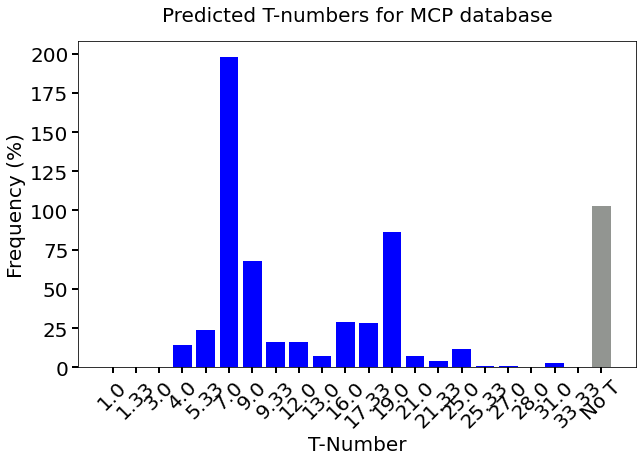

In [26]:
y_pos = np.arange(len(tps3))

# create a count of each T-number in the list
performance = []
for i in tps:
    performance.append(Counter(words)[i])
performance.append(Counter(words)[0])
performance=np.asarray(performance)
performance

# create a color map to make the 'No T' group gray
barColors = []
for p in y_pos:
    if (p==np.max(y_pos)):
        barColors.append('#929591')
    else:
        barColors.append('blue')
barColors = np.asarray(barColors)  

# plot the histogram
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
plt.bar(y_pos, performance, align='center', color=barColors)
plt.xticks(y_pos, tps3, fontsize=font2, rotation=45)
ax.tick_params(length=6, width=2)
plt.yticks(fontsize=font2)
plt.ylabel('Frequency (%)', fontsize=font2)
plt.xlabel('T-Number', fontsize=font2)
ax.set_title('Predicted T-numbers for MCP database', fontsize=font2, pad=20)


In [27]:
# count how many phages in the MCP database have more than one T-number within the error
tWhole = []
MCPtcount = np.zeros(len(tRaw1))

tps_h1 = np.asarray([i for i in tps_h if (i in tps_t)])

for k in range(len(tRaw1)):
    tWhole.append(int(IxMCP[k]))
    tWhole.append(xMCP1[k])
    tWhole.append(tRaw1[k])   
    tWhole.append(tNearestValid(tps,tRaw1[k],errMargin))
    for j in tps: 
        if (tRaw1[k] < (j + j*errMargin) and tRaw1[k] > (j - j*errMargin)):
            MCPtcount[k] = MCPtcount[k] + 1
            if j in tps_h1:
                MCPtcount[k] = MCPtcount[k] + 1
    tWhole.append(MCPtcount[k])

tWhole=np.asarray(tWhole).reshape(-1,5)    
print("IX -- Genome size -- tRaw -- tNearestValid -- Count of T")
print(tWhole)
# assign a variable to the max T-count
maxTCount = int(np.max(MCPtcount))
print("max count = ", maxTCount) 

# create a csv file 
#with open('twhole.csv', 'w') as csvfile:
#    writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
#    for row in tWhole:
#        writer.writerow(row)

IX -- Genome size -- tRaw -- tNearestValid -- Count of T
[[  0.          28.015        5.2975278    5.33         1.        ]
 [  1.          49.425        7.94625969   0.           0.        ]
 [  2.          35.43         6.26480266   0.           0.        ]
 ...
 [666.          38.297        6.62281576   7.           1.        ]
 [667.          28.921        5.41932698   5.33         1.        ]
 [668.          53.684        8.42948654   9.           1.        ]]
max count =  4


In [28]:
tpivC= Counter()
for T in tWhole[:,3]:
    tpivC[T] += 1
tpivC

Counter({5.33: 24,
         0.0: 103,
         7.0: 198,
         19.0: 86,
         9.0: 68,
         12.0: 16,
         16.0: 29,
         17.33: 28,
         9.33: 16,
         4.0: 14,
         25.0: 12,
         21.0: 7,
         31.0: 3,
         13.0: 7,
         21.33: 4,
         25.33: 1,
         27.0: 1})

In [29]:
# make an array that has a row for each T-number and a column for the number of hits, total and percentage for each
tPivot = np.zeros((len(tps2),(maxTCount*2+2)))

# populate column 1 with T-numbers
for i in range(tPivot.shape[0]):
    tPivot[i][0]=tps2[i]

# for each possible count
for k in range(maxTCount+1):
    # for each possible T
    for j in range(tPivot.shape[0]):
        # for each phage in the database
        for i in range(tWhole.shape[0]):
            # if the predicted T-number matches the T-number on the pivot table
            # and the count of possible T-numbers matches the column of possible predictions, increase the counter
            if tWhole[i,3]==tPivot[j,0] and tWhole[i,4]==k:
                tPivot[j,k+1]=tPivot[j,k+1]+1

# add 0 and 1, since those are both considered 1 prediction
tPivot[:,1] = tPivot[:,1]+tPivot[:,2]

#scoot the remaining predictions over
for i in range(maxTCount+1):
    tPivot[:,i+2] = tPivot[:,i+3]

# create the summation column 
tPivot[:,maxTCount+1]=0
for i in range(maxTCount):
    tPivot[:,maxTCount+1]=tPivot[:,maxTCount+1]+tPivot[:,i+1]

# calculate the percentages
for i in range(tPivot.shape[0]):
    if tPivot[i,maxTCount+1] !=0:
        for k in range(maxTCount):
            tPivot[i,maxTCount+k+2] = tPivot[i,k+1]/tPivot[i,maxTCount+1]

#with open('tpivot.csv', 'w') as csvfile:
#    writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
#    for row in tPivot:
#        writer.writerow(row)

print("T-Number -- 1 pred -- 2 pred -- 3 pred -- 4 pred -- total -- % 1 -- % 2 -- % 3 -- % 4 ")
print(tPivot)
        
# create a csv file 
#with open('tpivot.csv', 'w') as csvfile:
#    writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
#    for row in tPivot:
#        writer.writerow(row)

T-Number -- 1 pred -- 2 pred -- 3 pred -- 4 pred -- total -- % 1 -- % 2 -- % 3 -- % 4 
[[0.00000000e+00 1.03000000e+02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.03000000e+02 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.33000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.00000000e+00 0.00000000e+00 1.40000000e+01 0.00000000e+00
  0.00000000e+00 1.40000000e+01 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.33000000e+00 2.40000000e+01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.40000000e+01 1.00000000e+00 0.00000000e+00
  0.

In [30]:
# sanity check that they all add to 1
for i in (range(tPivot.shape[0])):
    print(np.sum(tPivot[i,6:10]))

1.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
0.0


In [31]:
# now disambiguate the data per count
T1 = []
T2 = []
T3 = []
T4 = []
pred1= []
pred2= []
pred3= []
pred4= []


for k in range(tWhole.shape[0]):
    
    if (tWhole[k][4]==1 or tWhole[k][4]==0):
        pred1.append(tWhole[k][1])
        T1.append(tWhole[k][3])
    if tWhole[k][4]==2:
        pred2.append(tWhole[k][1])
        T2.append(tWhole[k][3])
    if tWhole[k][4]==3:
        pred3.append(tWhole[k][1])
        T3.append(tWhole[k][3])
    if tWhole[k][4]==4:
        pred4.append(tWhole[k][1])
        T4.append(tWhole[k][3])
        
plotdata_e1 = [pred1,pred2,pred3,pred4]

In [32]:
len(T1)+len(T2)+len(T3)+len(T4)

617

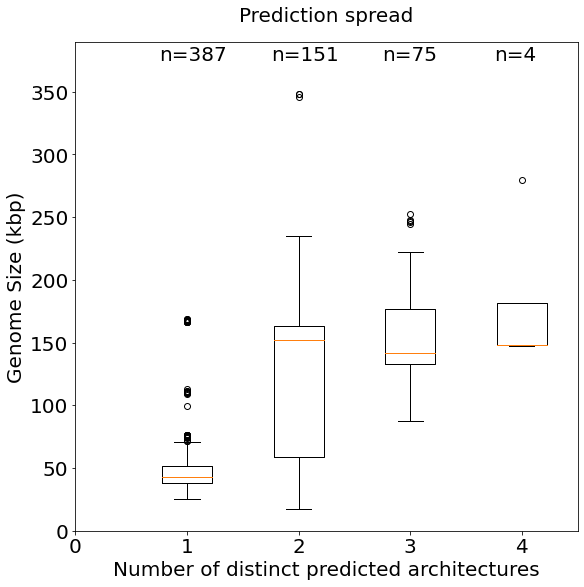

In [33]:
# box plot for evalue=1
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,9))
plt.boxplot(plotdata_e1)
plt.xlabel("Number of distinct predicted architectures", fontsize=font2) 
plt.ylabel("Genome Size (kbp)", fontsize=font2)
plt.title("Prediction spread", fontsize=font2, pad=20)
plt.ylim(0,390)
plt.xticks(np.arange(5), ('0','1','2','3','4'), fontsize=font2)
plt.yticks(fontsize=font2)

allplotdatan = 0
plotdatan = []
for i in range(len(plotdata_e1)):
    DNAfb = "n=" + str(len(plotdata_e1[i]))
    plotdatan.append(DNAfb)
    allplotdatan = allplotdatan+len(plotdata_e1[i])
    plt.text(i+1-.25, 375, DNAfb, {'fontsize': font2})
    

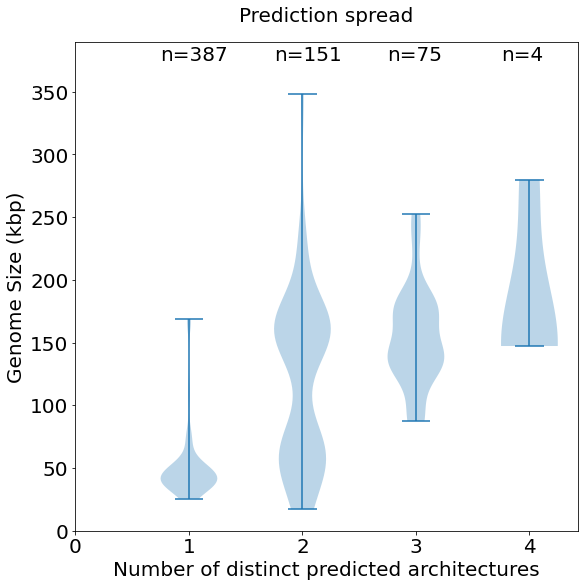

In [22]:
# box plot for evalue=1
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,9))
plt.violinplot(plotdata_e1)
plt.xlabel("Number of distinct predicted architectures", fontsize=font2) 
plt.ylabel("Genome Size (kbp)", fontsize=font2)
plt.title("Prediction spread", fontsize=font2, pad=20)
plt.ylim(0,390)
plt.xticks(np.arange(5), ('0','1','2','3','4'), fontsize=font2)
plt.yticks(fontsize=font2)

allplotdatan = 0
plotdatan = []
for i in range(len(plotdata_e1)):
    DNAfb = "n=" + str(len(plotdata_e1[i]))
    plotdatan.append(DNAfb)
    allplotdatan = allplotdatan+len(plotdata_e1[i])
    plt.text(i+1-.25, 375, DNAfb, {'fontsize': font2})
    

In [21]:
[387/n, 151/n, 75/n, 4/n]

[0.6272285251215559,
 0.24473257698541329,
 0.12155591572123177,
 0.006482982171799027]

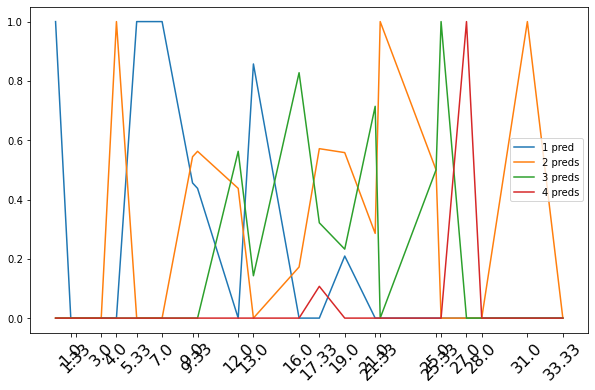

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

plt.plot(tPivot[:,0], tPivot[:,6],label = "1 pred")
plt.plot(tPivot[:,0], tPivot[:,7],label = "2 preds")
plt.plot(tPivot[:,0], tPivot[:,8],label = "3 preds")
plt.plot(tPivot[:,0], tPivot[:,9],label = "4 preds")
plt.legend()
plt.xticks(tps, tps, fontsize=font3, rotation=45);

In [35]:
one_pred = tPivot[:,6]
two_pred = tPivot[:,7]
three_pred = tPivot[:,8]
four_pred = tPivot[:,9]


pred11 = []
for i in (one_pred[1:]):
    pred11.append(i)
pred11.append(one_pred[0])
pred11 = np.asarray(pred11)

pred21 = []
for i in (two_pred[1:]):
    pred21.append(i)
pred21.append(two_pred[0])
pred21 = np.asarray(pred21)

pred31 = []
for i in (three_pred[1:]):
    pred31.append(i)
pred31.append(three_pred[0])
pred31 = np.asarray(pred31)

pred41 = []
for i in (four_pred[1:]):
    pred41.append(i)
pred41.append(four_pred[0])
pred41 = np.asarray(pred41)

meanspace1 = pred11 + pred21
meanspace2 = meanspace1 + pred31
meanspace3 = meanspace2 + pred41

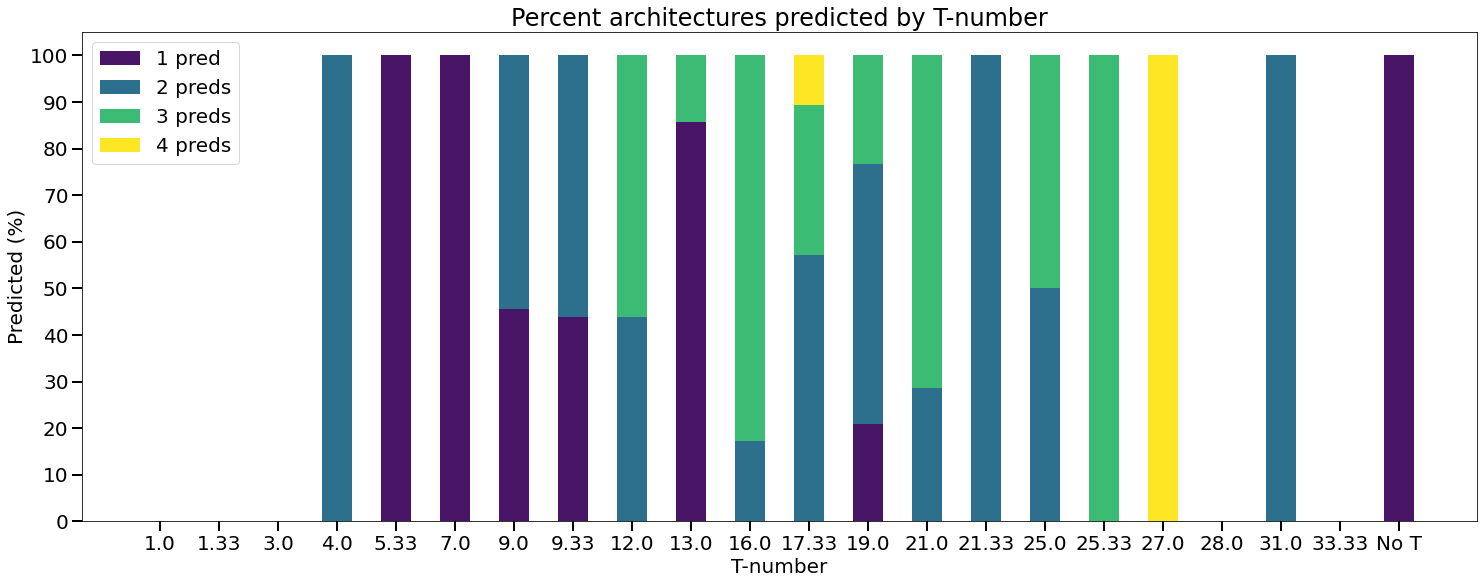

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,9))


ind = np.arange(tPivot.shape[0])    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, pred11, width, color='#481567ff', label='1 pred')
p2 = plt.bar(ind, pred21, width, color='#2d708eff', bottom=pred11, label='2 preds')
p3 = plt.bar(ind, pred31, width, color='#3cbb75ff', bottom=meanspace1, label='3 preds')
p4 = plt.bar(ind, pred41, width, color='#fde725ff', bottom=meanspace2, label='4 preds')

y_ind = np.arange(0, 1.1, .1)
y_tc = []
for i in y_ind:
    y_tc.append(int(i*100))
y_tc

plt.ylabel('Predicted (%)',fontsize=font2)
plt.xlabel('T-number',fontsize=font2)
plt.title('Percent architectures predicted by T-number',fontsize=font1)
plt.xticks(ind, tps3,fontsize=font2)
plt.yticks(y_ind,y_tc,fontsize=font2)
ax.tick_params(length=10, width=2)
plt.ylim(0,1.05)
plt.legend(fontsize=font2)

plt.savefig("Fig3c-Percent architectures predicted by T-number.png")
plt.savefig("Fig3c-Percent architectures predicted by T-number.svg");
plt.show()

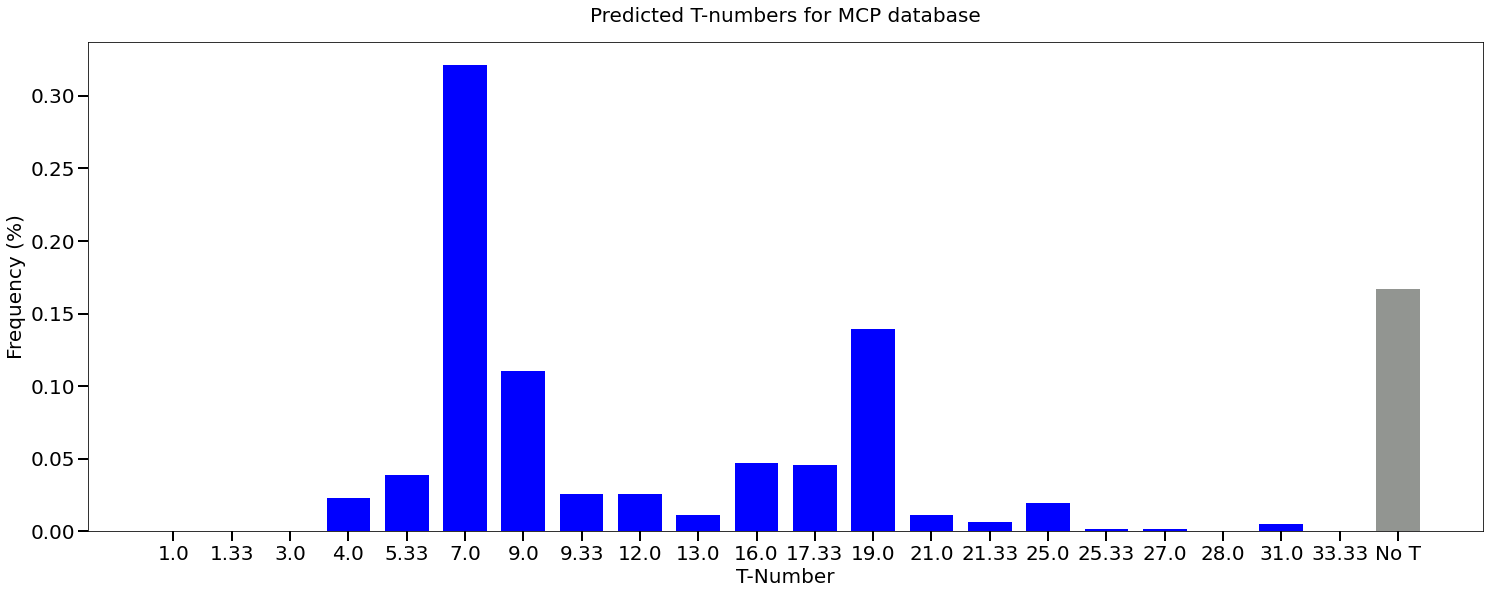

In [37]:
ind = np.arange(tPivot.shape[0])    # the x locations for the groups
width = 0.75 


# create a count of each T-number in the list with zero at the end
performance = []
for i in tps:
    performance.append(Counter(words)[i])
performance.append(Counter(words)[0])
performance=np.asarray(performance)/np.sum(performance)


# create a color map to make the 'No T' group gray
barColors = []
for p in ind:
    if (p==np.max(ind)):
        barColors.append('#929591')
    else:
        barColors.append('blue')
barColors = np.asarray(barColors)  

# plot the histogram
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,9))
plt.bar(ind, performance, width, align='center',color=barColors)
plt.xticks(ind, tps3, fontsize=font2)
#plt.xticks(ind, objects2, fontsize=font2, rotation=45)
plt.yticks(fontsize=font2)
plt.ylabel('Frequency (%)', fontsize=font2)
plt.xlabel('T-Number', fontsize=font2)
ax.set_title('Predicted T-numbers for MCP database', fontsize=font2, pad=20)
ax.tick_params(length=10, width=2)
plt.savefig("Fig3b-Predicted T-numbers for MCP.png")
plt.savefig("Fig3b-Predicted T-numbers for MCP.svg");

In [38]:
tps_t[:14]

array([ 1,  3,  4,  7,  9, 12, 13, 16, 19, 21, 25, 27, 28, 31])

In [39]:
TDNA_t = np.exp((np.log(tps_t[:14])-tMod[2])/tMod[0])
print(TDNA_t)

[  2.71369912  12.63614889  18.90387229  41.38533419  58.83933768
  88.02455041  98.46385437 131.68607567 167.50969542 192.70789497
 245.99241971 273.98123342 288.29396256 332.45157211]


In [40]:
tps_h[:11]

array([ 1.33,  4.  ,  5.33,  9.33, 12.  , 16.  , 17.33, 21.33, 25.33,
       28.  , 33.33])

In [41]:
TDNA_h = np.exp((np.log(tps_h[:11])-tMod[2])/tMod[0])
print(TDNA_h)

[  4.04553171  18.90387229  28.25573708  61.88213564  88.02455041
 131.68607567 147.26377226 196.96128748 250.55090292 288.29396256
 367.95690114]


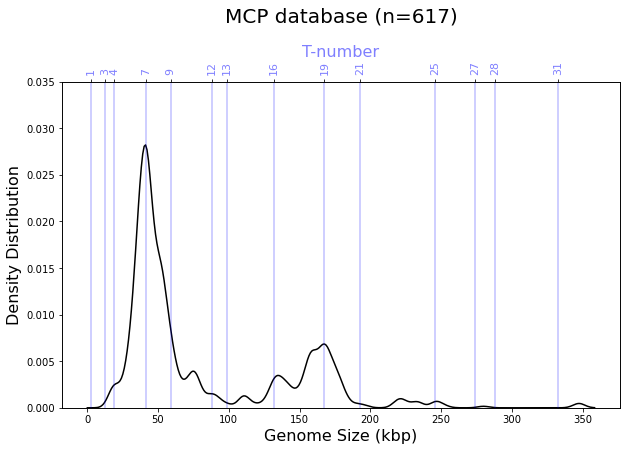

In [51]:
# MCP database kernel dist
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
plt.plot(xlinMCP, pdfMCP, color='black', label='MCP db') 
plt.ylim((0,.035))
#plt.legend(loc="upper right")

y_range = np.linspace(0,.035,2)

tnums = tps_t[:14]
x_tnums = TDNA_t

for i in range(len(tnums)):
    x_range = [x_tnums[i],x_tnums[i]]
    plt.plot(x_range,y_range, color="blue",alpha=0.25)
    
# add another x
new_tick_locations = np.array(x_tnums)
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tnums, fontsize=11, color="blue",alpha=0.5, rotation=90)
ax2.set_xlabel("T-number", fontsize=font3, color="blue",alpha=0.5)

#plt.title("MCP database (n=628)", fontsize=font2)
ax.set_title("MCP database (n=617)", fontsize=font2, pad=60)
ax.set_xlabel("Genome Size (kbp)", fontsize=font3)
ax.set_ylabel("Density Distribution", fontsize=font3)
plt.savefig("MCP Kernel Density (hex).svg");

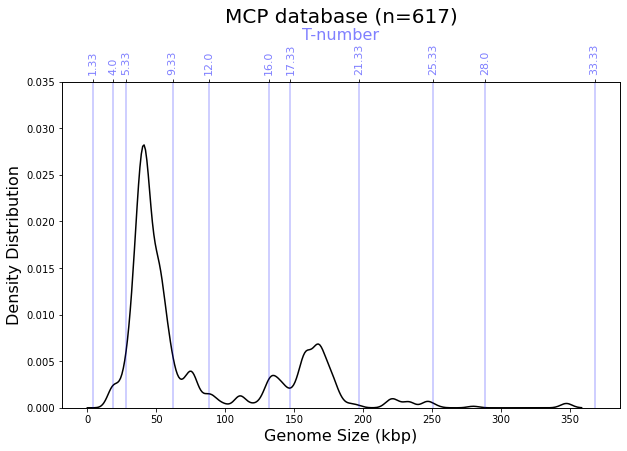

In [52]:
# MCP database kernel dist
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
plt.plot(xlinMCP, pdfMCP, color='black', label='MCP db') 
plt.ylim((0,.035))
#plt.legend(loc="upper right")

y_range = np.linspace(0,.035,2)

tnums = tps_h[:11]
x_tnums = TDNA_h

for i in range(len(tnums)):
    x_range = [x_tnums[i],x_tnums[i]]
    plt.plot(x_range,y_range, color="blue",alpha=0.25)
    
# add another x
new_tick_locations = np.array(x_tnums)
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tnums, fontsize=11, color="blue",alpha=0.5, rotation=90)
ax2.set_xlabel("T-number", fontsize=font3, color="blue",alpha=0.5)

#plt.title("MCP database (n=617)", fontsize=font2)
ax.set_title("MCP database (n=617)", fontsize=font2, pad=60)
ax.set_xlabel("Genome Size (kbp)", fontsize=font3)
ax.set_ylabel("Density Distribution", fontsize=font3)
plt.savefig("MCP Kernel Density (trihex).svg");

In [44]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(1, 30, 30)},
                    cv=200) # 20-fold cross-validation
grid.fit(xMCP1[:, None])
print(grid.best_params_)

{'bandwidth': 4.0}


In [45]:
tNF = []
for i in range(len(tNearest1)):
    if tNearest1[i]==0:
        tNF.append(tNearestFloor(tps,tRaw1[i]))
tNF = np.asarray(tNF)

words2 = tNF
print(Counter(words2).keys()) # equals to list(set(words))
print(Counter(words2).values()) # counts the elements' frequency

dict_keys([7.0, 5.33, 9.33, 13.0])
dict_values([46, 33, 21, 3])


In [46]:
len(tps3)

22

In [47]:
print("MCP Database phages with no assigned T-number: ", tpivC[0])
print("Percent of total: ", np.round(tpivC[0]/n,2))


MCP Database phages with no assigned T-number:  103
Percent of total:  0.17


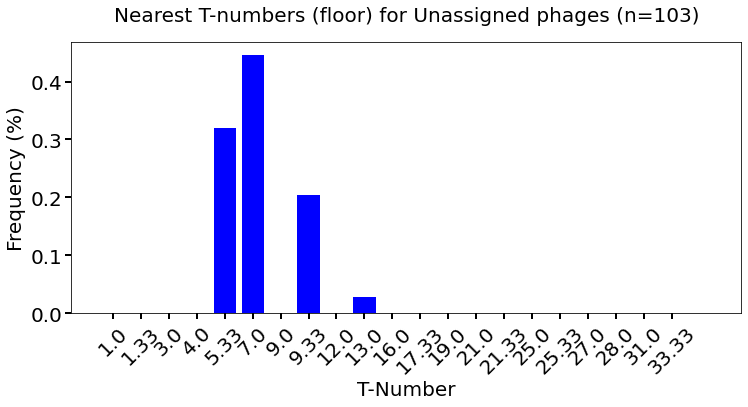

In [48]:
# create a count of each T-number in the list
performance2 = []
for i in tps:
    performance2.append(Counter(words2)[i])
performance2.append(0)
performance2=np.asarray(performance2)/np.sum(performance2)
#performance2

# plot the histogram
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))
plt.bar(y_pos, performance2, align='center', color=barColors)
plt.xticks(y_pos[:21], tps3[:21], fontsize=font2, rotation=45)
ax.tick_params(length=6, width=2)
plt.yticks(fontsize=font2)
plt.ylabel('Frequency (%)', fontsize=font2)
plt.xlabel('T-Number', fontsize=font2)
ax.set_title('Nearest T-numbers (floor) for Unassigned phages (n=103)', fontsize=font2, pad=20)

plt.savefig("Fig3bSI-Predicted T-numbers for Unassigned MCP.png")
plt.savefig("Fig3bSI-Predicted T-numbers for Unassigned MCP.svg");

In [49]:
# save kernel state
# note that all csv_writer functions are commented out, since they cannot be pickled
import dill
dill.dump_session('item2_updated.db')

In [4]:
## load kernel state
## rerun imports cells (#1 and #2) first
#import dill
#dill.load_session('item2_updated.db')
